#Image captioing model
This model uses seq2seq architecure with teacher forcing to caption images from MS COCO dataset.

Example image from model after training:

![](https://drive.google.com/uc?id=1OE18Bi1EEUTU9KNDvUo7gAzLPAiJLXlg)

Note that attention can be added upon this architecure, but it takes more time to train.

###Importing relevant libraries

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras.backend as K

keras = tf.keras

Using TensorFlow backend.


##Setting config parameters

In [0]:
max_cap_len = 15  # Determines max length of captioning sentences
img_dimension = 299 # Determines the height and width of images
num_words = 10000 # Determines vocab size to tokenize and train on
encoding_size = 256 # Determines dimension of the encodings of images
LSTM_size = 768 
batch_size = 64
n_epochs = 15
Buffer_size = 1000
validation_and_test_split = 0.2
test_to_val_split = 0.5
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

##Data Preprocessing


###Downloading the MS COCO dataset

Both this cell and the one below it were copied from a google documentation.

I have done some editing like stripping out most of 'a', 'an' and 'the' words as they had little value and were too common.

Link of the google doucmenatin:

https://www.tensorflow.org/tutorials/text/image_captioning#model

In [0]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder


13510574080/13510573713 [==============================] - 370s 0us/step


###Reading the data

In [0]:
# Read the json file
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = annot['caption']

    #Removing the word 'a' from captions
    caption = caption.replace(" a "," ")
    caption = caption.replace("A ","")
    #Removing the word 'an' from captions
    caption = caption.replace("An ","")
    caption = caption.replace(" an "," ")
    #Removing the word 'the' from captions
    caption = caption.replace(" the "," ")
    caption = caption.replace("The ","")

    #Load only captions that don't exceed maximum length
    if len(caption.split(" ")) > max_cap_len:
      continue
    else:
      caption = '<sos> ' + caption + ' <eos>'
      image_id = annot['image_id']
      full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

      all_img_name_vector.append(full_coco_image_path)
      all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,
                                                                      img_name_vector,
                                                                      test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))


Loaded 409297 samples
Loaded 327437 train samples
Loaded 40930 valid samples
Loaded 40930 test samples


###Tokenizing and padding captions

In [0]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words
                                         ,filters ="!?,'()_-+=&*$#@.",oov_token="<unk>")
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)
if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Examlpe:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1,size=1)[0]])
print("Found %d unique words" %(words))

Examlpe: [  2 831 671 685  13   6  59  24 973  11 347 140 543   3   0   0   0]
Found 10000 unique words


In [0]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

###Defining preprocessing functions of dataset

In [0]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

In [0]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [0]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [0]:
#Creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1)
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [0]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256).prefetch(1)

##Building the model

###Downloading Inception and freezing it.

In [0]:
from keras.applications.inception_v3 import preprocess_input


incep = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False
incep.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

###Completing the model

In [0]:
img = keras.layers.Input(shape=(img_dimension,img_dimension,3))

teacher_forcing = keras.layers.Input(shape=(max_cap_len+1))

initial_state = keras.layers.Input(shape=(LSTM_size))

img_preprocessed = preprocess_input(img)

encoding = incep(img_preprocessed)


encoding_layer = keras.layers.Dense(encoding_size, activation='relu') # Encodes image
encoding = encoding_layer(encoding) # encodings shape is (8,8,encoding_size)

encoding = keras.layers.Flatten()(encoding)

repeater = keras.layers.RepeatVector(max_cap_len+1)

encoding = repeater(encoding)

embedding_layer = keras.layers.Embedding(words+1, 256, mask_zero=True)
dropout_on_embbeds = keras.layers.Dropout(0.15)

embedds = embedding_layer(teacher_forcing)
embedds = dropout_on_embbeds(embedds)

conc = keras.layers.Concatenate()

decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_sequences=True,return_state=True,dropout=0.2)

decoder_dense_layer = keras.layers.Dense(words + 1, activation=None, name='output_layer')

h = initial_state
c = initial_state


decoder_lstm_input = conc([encoding, embedds])
  
lstm_out , h , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(lstm_out)

model = keras.models.Model([img,initial_state,teacher_forcing],out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_Sub[0][0]            
______________________________________________________________________________________________

###Defining custom loss function

In [0]:
'''This custom loss avoids the bug in keras when using sparse-categorical-crossentropy
   loss with a time distributed dense layer. It also masks the padding of squences'''

def sparse_it_up(yTrue,yPreds):
  yTrue = tf.cast(yTrue, tf.int32)
  mask = tf.math.logical_not(tf.math.equal(yTrue,0))
  mask = tf.cast(mask, dtype=tf.float32)
  yTrue = tf.one_hot(yTrue,words + 1)
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(yTrue, yPreds)*mask)

###Compiling the model and setting callbacks

In [0]:
model.compile(optimizer=keras.optimizers.Nadam(0.001),
              loss = sparse_it_up, metrics=['accuracy'])
chk = keras.callbacks.ModelCheckpoint('Image_captioning.hdf5',save_best_only=True, monitor='val_accuracy',verbose =1)
ES = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=1)

##Training the model
One training epoch takes about 35 minutes on google colab with gpu.

So, get busy doing something else for a while! or just go for a smaller num_examples set from the configuration cell.

In [0]:
model.fit(dataset, epochs=15,validation_data=dataset_val,callbacks=[ES,chk])

Epoch 1/15
5117/5117 [==============================] - ETA: 0s - loss: 1.3419 - accuracy: 0.1970
Epoch 00001: val_accuracy improved from -inf to 0.22269, saving model to Image_captioning.hdf5
5117/5117 [==============================] - 2407s 470ms/step - loss: 1.3419 - accuracy: 0.1970 - val_loss: 1.1915 - val_accuracy: 0.2227
Epoch 2/15
5117/5117 [==============================] - ETA: 0s - loss: 1.1108 - accuracy: 0.2333
Epoch 00002: val_accuracy improved from 0.22269 to 0.23324, saving model to Image_captioning.hdf5
5117/5117 [==============================] - 2393s 468ms/step - loss: 1.1108 - accuracy: 0.2333 - val_loss: 1.1402 - val_accuracy: 0.2332
Epoch 3/15
5117/5117 [==============================] - ETA: 0s - loss: 0.9959 - accuracy: 0.2540
Epoch 00003: val_accuracy improved from 0.23324 to 0.23535, saving model to Image_captioning.hdf5
5117/5117 [==============================] - 2416s 472ms/step - loss: 0.9959 - accuracy: 0.2540 - val_loss: 1.1394 - val_accuracy: 0.2353
E

In [0]:
# Loading the best validation accuracy score weights
model.load_weights("Image_captioning.hdf5")

##Evaluating the model on test dataset

In [0]:
def preprocess_func_test(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_test,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [0]:
captions_test = tok.texts_to_sequences(caption_test)
captions_test= keras.preprocessing.sequence.pad_sequences(captions_test, padding='post',maxlen=max_cap_len + 2)

path_index_vec_test = np.array(list(range(0,len(img_name_vector_test)))).reshape(-1,1)

dataset1_test = tf.data.Dataset.from_tensor_slices(path_index_vec_test)
dataset2_test = tf.data.Dataset.from_tensor_slices(captions_test)
dataset_test = tf.data.Dataset.zip((dataset1_test,dataset2_test))
dataset_test = dataset_test.map(preprocess_func_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [0]:
model.evaluate(dataset_test.batch(256).prefetch(1))

160/160 [==============================] - 248s 2s/step - loss: 1.1469 - accuracy: 0.2356


[1.1469460725784302, 0.23564012348651886]

##Building a model instance for prediction
This instance works on a sequence length of 1. We do that for teacher forcing as we don't have the next target of a sequence untill we predict a step of that sequence.

In [0]:
def build_encoder():
  img_inp = keras.layers.Input(shape=(img_dimension,img_dimension,3)),
  encodings = incep(img_inp)
  encodings = encoding_layer(encodings)
  encodings = keras.layers.Flatten()(encodings)
  model_encoder = keras.models.Model(img_inp,encodings)
  return model_encoder

In [0]:
pred_encoder = build_encoder()
pred_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dense (Dense)                (None, 8, 8, 256)         524544    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
Total params: 22,327,328
Trainable params: 524,544
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
encodings_input = keras.layers.Input(shape=(8*8*encoding_size))
teacher_forcing = keras.layers.Input(shape=(1))
initial_h = keras.layers.Input(shape=(LSTM_size))
initial_c = keras.layers.Input(shape=(LSTM_size))

h = initial_h
c = initial_c

embedds = embedding_layer(teacher_forcing)

lstm_in = conc([tf.expand_dims(encodings_input,1),embedds])



lstm_out , h , c = decoder_lstm_layer(lstm_in,initial_state=[h,c])

out = tf.nn.softmax(decoder_dense_layer(lstm_out))

pred_decoder = keras.models.Model([encodings_input,initial_h,initial_c,teacher_forcing],[out,h,c])
pred_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 16384)]      0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 1, 16384)]   0           input_10[0][0]                   
__________________________________________________________________________________________________
embedding (Embedding)           multiple             2560256     input_11[0][0]                   
____________________________________________________________________________________________

###Prediction function
This function takes its input as path of an image and captions it

In [0]:
def caption_image(path):
  image = load_img(path)#/255.0
  img_input = preprocess_input(image)

  encodings = pred_encoder.predict(tf.reshape(img_input,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = h
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    props, h, c = pred_decoder.predict([encodings,h, c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  print(' '.join(texts))
  plt.imshow(image/255.0)
  plt.axis("off")

###Some random predictions for fun.
Apparently the model performs well, but it sometimes deviates from its desired destination when it starts describing some details.

I have split some predictions to the good, the meh and the ugly.

####The good

<sos> four red airplanes flying in formation in blue sky <eos>


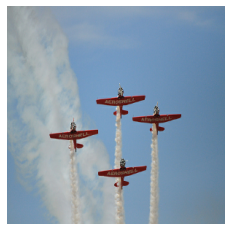

In [0]:
caption_image(img_name_vector_test[10302])

<sos> young boy brushing his teeth with toothbrush <eos>


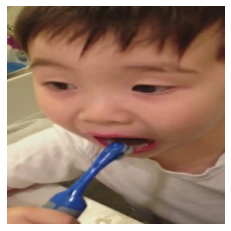

In [0]:
caption_image(img_name_vector_test[1785])

<sos> a big car parked on beach with some people <eos>


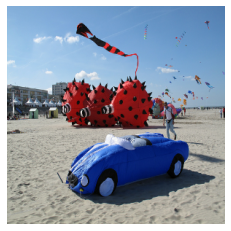

In [0]:
caption_image(img_name_vector_test[28512])

<sos> woman pouring glass of wine in kitchen <eos>


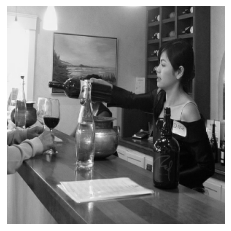

In [0]:
caption_image(img_name_vector_test[18])

<sos> blurry image of person walking on street corner <eos>


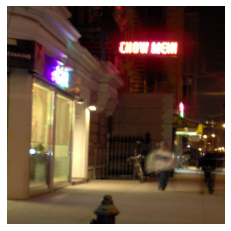

In [0]:
caption_image(img_name_vector_test[110])

####The meh

<sos> living room with blue and white checkered walls <eos>


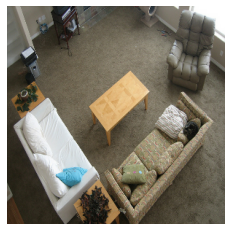

In [0]:
caption_image(img_name_vector_test[8658])

<sos> vase sitting on table with flowers in it <eos>


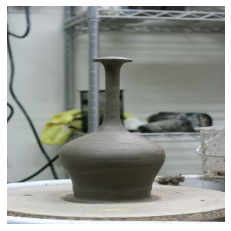

In [0]:
caption_image(img_name_vector_test[128])

<sos> a woman in white shirt and cellphone in room <eos>


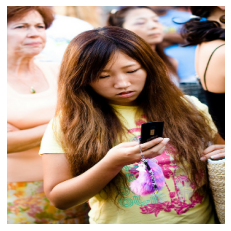

In [0]:
caption_image(img_name_vector_test[1006])

<sos> computer keyboard and mouse are on desk <eos>


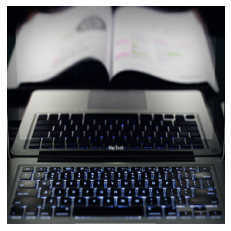

In [0]:
caption_image(img_name_vector_test[2])

####The ugly

<sos> two people sitting on bench with their feet <eos>


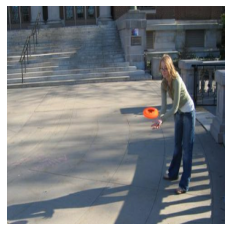

In [0]:
caption_image(img_name_vector_test[8192])

<sos> some fruit are sitting in bowl with oranges <eos>


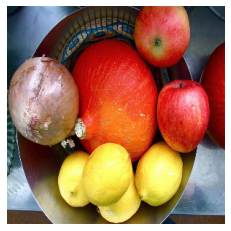

In [0]:
caption_image(img_name_vector_test[776])

<sos> a close up of person holding cake <eos>


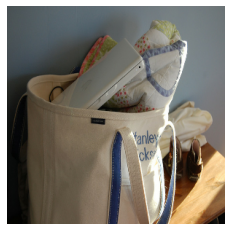

In [0]:
caption_image(img_name_vector_test[2135])

<sos> group of people sitting at table with pizza <eos>


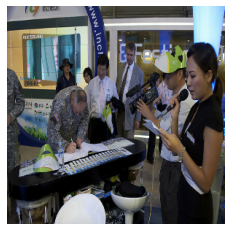

In [0]:
caption_image(img_name_vector_test[10248])

##Saving the results so far

###Saving the model

In [0]:
pred_encoder.save("Encoder.hdf5")
pred_decoder.save("Decoder.hdf5")

###Saving the tokenizer's dictionary

In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)